based on https://jhat.readthedocs.io/en/latest/examples/plot_b_nircam.html

In [1]:
%matplotlib inline


# JWST NIRCAM

Aligning JWST/NIRCAM images with JHAT.


An example NIRCam Dataset is downloaded, and then a series of
alignment methods are used. For more information on the
key parameters used for alignment see 
`params:Useful Parameters`.



In [19]:
import sys,os,glob
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.nddata import extract_array
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy.wcs.utils import skycoord_to_pixel
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from astroquery.mast import Observations
from astropy.visualization import (simple_norm,LinearStretch)

import jhat
from jhat import jwst_photclass,st_wcs_align

In [4]:
from astroquery.gaia import Gaia

## Relative Alignment

**Download some Data**

For this example we download 2 JWST NIRCam images from MAST. They're
the same field but different filters. Note that 
the code will also work for level 3 data images.



In [17]:
obs_table1 = Observations.query_criteria(obs_id='jw02107-o041_t019_nircam_clear-f200w')
data_products_by_obs = Observations.get_product_list(obs_table1)
data_products_by_obs = data_products_by_obs[data_products_by_obs['calib_level']==2]
data_products_by_obs = data_products_by_obs[data_products_by_obs['productSubGroupDescription']=='CAL']
data_products_by_obs = data_products_by_obs[data_products_by_obs['obs_id']=='jw02107041001_02101_00001_nrcb1']

In [18]:
data_products_by_obs

<Table masked=True length=1>
 obsID   obs_collection dataproduct_type ... dataRights calib_level filters
  str8        str4            str5       ...    str6       int64      str5 
-------- -------------- ---------------- ... ---------- ----------- -------
87617603           JWST            image ...     PUBLIC           2   F200W

In [19]:
Observations.download_products(data_products_by_obs,extension='fits')

<Table length=1>
                                         Local Path                                          ...
                                           str92                                             ...
-------------------------------------------------------------------------------------------- ...
./mastDownload/JWST/jw02107041001_02101_00001_nrcb1/jw02107041001_02101_00001_nrcb1_cal.fits ...

In [20]:
obs_table2 = Observations.query_criteria(obs_id='jw02107-o041_t019_nircam_clear-f360m')
data_products_by_obs = Observations.get_product_list(obs_table2)
data_products_by_obs = data_products_by_obs[data_products_by_obs['calib_level']==2]
data_products_by_obs = data_products_by_obs[data_products_by_obs['productSubGroupDescription']=='CAL']
data_products_by_obs = data_products_by_obs[data_products_by_obs['obs_id']=='jw02107041001_02101_00001_nrcblong']

In [21]:
data_products_by_obs

<Table masked=True length=1>
 obsID   obs_collection dataproduct_type ... dataRights calib_level filters
  str8        str4            str5       ...    str6       int64      str5 
-------- -------------- ---------------- ... ---------- ----------- -------
87617252           JWST            image ...     PUBLIC           2   F360M

In [22]:
Observations.download_products(data_products_by_obs,extension='fits')

<Table length=1>
                                            Local Path                                             ...
                                              str98                                                ...
-------------------------------------------------------------------------------------------------- ...
./mastDownload/JWST/jw02107041001_02101_00001_nrcblong/jw02107041001_02101_00001_nrcblong_cal.fits ...

**Examine the Reference Image**




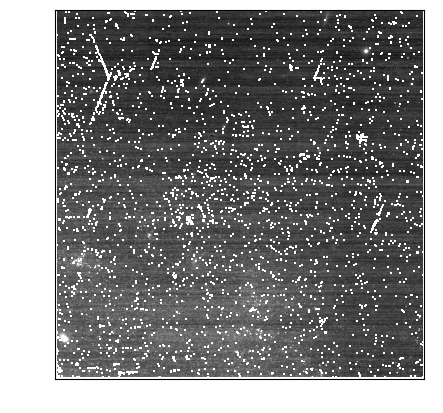

In [3]:
ref_image = glob.glob('jwstred_temp/jw02107041001_02101_00001_nrcb1_cal.fits')[0]

ref_fits = fits.open(ref_image)
ref_data = fits.open(ref_image)['SCI',1].data
norm1 = simple_norm(ref_data,stretch='linear',min_cut=-.5,max_cut=3)

plt.imshow(ref_data, origin='lower',
                      norm=norm1,cmap='gray')
plt.gca().tick_params(labelcolor='none',axis='both',color='none')
plt.show()

**Zoom in to see the offset**

Here add an artificial offset to the wcs, and then we see the 
same star in both images at the same ra/dec
location, demonstrating a large offset between
the images.  



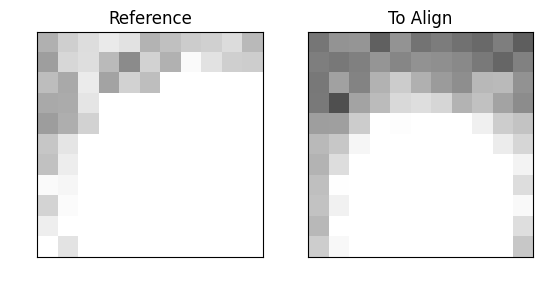

In [24]:
star_location = SkyCoord('23:09:41.0532','-43:26:41.128',unit=(u.hourangle,u.deg))
align_image = glob.glob('jwstred_temp/jw02107041001_02101_00001_nrcblong_cal.fits')[0]
align_fits = fits.open(align_image)
align_fits['SCI',1].header['CRPIX1']+=1
align_fits['SCI',1].header['CRPIX2']+=1
align_fits.writeto(align_image,overwrite=True)

align_data = fits.open(align_image)['SCI',1].data
ref_y,ref_x = skycoord_to_pixel(star_location,wcs.WCS(ref_fits['SCI',1],ref_fits))
align_y,align_x = skycoord_to_pixel(star_location,wcs.WCS(align_fits['SCI',1],align_fits))

ref_cutout = extract_array(ref_data,(11,11),(ref_x,ref_y))
align_cutout = extract_array(align_data,(11,11),(align_x,align_y))
norm1 = simple_norm(ref_cutout,stretch='linear',min_cut=-.5,max_cut=3)
norm2 = simple_norm(align_cutout,stretch='linear',min_cut=-.5,max_cut=3)
fig,axes = plt.subplots(1,2)
axes[0].imshow(ref_cutout, origin='lower',
                      norm=norm1,cmap='gray')
axes[1].imshow(align_cutout, origin='lower',
                      norm=norm2,cmap='gray')
axes[0].set_title('Reference')
axes[1].set_title('To Align')
axes[0].tick_params(labelcolor='none',axis='both',color='none')
axes[1].tick_params(labelcolor='none',axis='both',color='none')

plt.show()

**Create a Photometric Catalog for Relative Alignment**

We choose one of the images to be the reference image, and then 
create a catalog that we will use to align the other image.



In [10]:
ref_image = glob.glob('jwstred_temp_gaia/jw01334001001_02101_00001_nrca4_cal.fits')[0]

In [11]:
jwst_phot = jwst_photclass()
jwst_phot.run_phot(imagename=ref_image,photfilename='auto',overwrite=True,ee_radius=80)
ref_catname = ref_image.replace('.fits','.phot.txt') # the default
refcat = Table.read(ref_catname,format='ascii')
print(refcat)

0 jwstred_temp_gaia/jw01334001001_02101_00001_nrca4_cal.phot.txt


2024-09-13 09:33:59,039 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.
2024-09-13 09:33:59,351 - stpipe.SourceCatalogStep - INFO - Using APCORR reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_apcorr_0004.fits
2024-09-13 09:33:59,365 - stpipe.SourceCatalogStep - INFO - Using ABVEGAOFFSET reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_abvegaoffset_0002.asdf
2024-09-13 09:33:59,366 - stpipe - INFO - Instrument: NIRCAM
2024-09-13 09:33:59,367 - stpipe - INFO - Detector: NRCA4
2024-09-13 09:33:59,367 - stpipe - INFO - Filter: F090W
2024-09-13 09:33:59,368 - stpipe - INFO - Pupil: CLEAR
2024-09-13 09:33:59,369 - stpipe - INFO - Subarray: FULL
2024-09-13 09:33:59,411 - stpipe - WARNING - model.meta.resample.pixel_scale_ratio was not found. Assuming the native detector pixel scale (i.e., pixel_scale_ratio = 1)


dmag 0.36200000000000004
aper_sum_7.5px annulus_median_7.5px aper_bkg_7.5px ...   x_idl      y_idl   
-------------- -------------------- -------------- ... ---------- ----------
   1282.769968             1.445329     254.050273 ... -18.643959 -31.473312
    272.537112             1.364692      239.87646 ...  -15.31883 -31.419365
   1104.006973             1.521235     267.392532 ...  -6.312187 -31.519364
    1623.61574             2.993575     526.190814 ...   7.933129 -31.537068
   2906.632796             3.634204     638.796214 ...  13.861517 -31.539625
   1536.176802             4.759752     836.637639 ...  16.211523 -31.581025
   2008.532597             3.631472     638.316078 ...   20.54461  -31.55208
   1399.745898             6.867782    1207.173183 ...    23.5698 -31.528641
   1090.518536             5.584095     981.535093 ...  24.234927 -31.568573
   1223.712559             4.554184      800.50433 ...  30.066456 -31.555231
           ...                  ...            ... 

**Align the second image**

The plots outputted here show the various steps used by jhat to
determine the true matching sources in the image, and the
subsequent correction needed for optimal alignment.



In [12]:
align_image = glob.glob('jwstred_temp_gaia/jw01334001001_02101_00002_nrca4_cal.fits')[0]

0 ./jwstred_temp/jw01334001001_02101_00002_nrca4.phot.txt


2024-09-13 09:37:05,486 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.
2024-09-13 09:37:05,805 - stpipe.SourceCatalogStep - INFO - Using APCORR reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_apcorr_0004.fits
2024-09-13 09:37:05,823 - stpipe.SourceCatalogStep - INFO - Using ABVEGAOFFSET reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_abvegaoffset_0002.asdf
2024-09-13 09:37:05,824 - stpipe - INFO - Instrument: NIRCAM
2024-09-13 09:37:05,826 - stpipe - INFO - Detector: NRCA4
2024-09-13 09:37:05,826 - stpipe - INFO - Filter: F090W
2024-09-13 09:37:05,827 - stpipe - INFO - Pupil: CLEAR
2024-09-13 09:37:05,828 - stpipe - INFO - Subarray: FULL
2024-09-13 09:37:05,862 - stpipe - WARNING - model.meta.resample.pixel_scale_ratio was not found. Assuming the native detector pixel scale (i.e., pixel_scale_ratio = 1)


dmag 0.2172
dmag 1.0
sharpness 0.9
roundness1 0.7
mag 24
x 2008
y 2008
reffile_d2d 0.2
*** Note: close plot to continue!


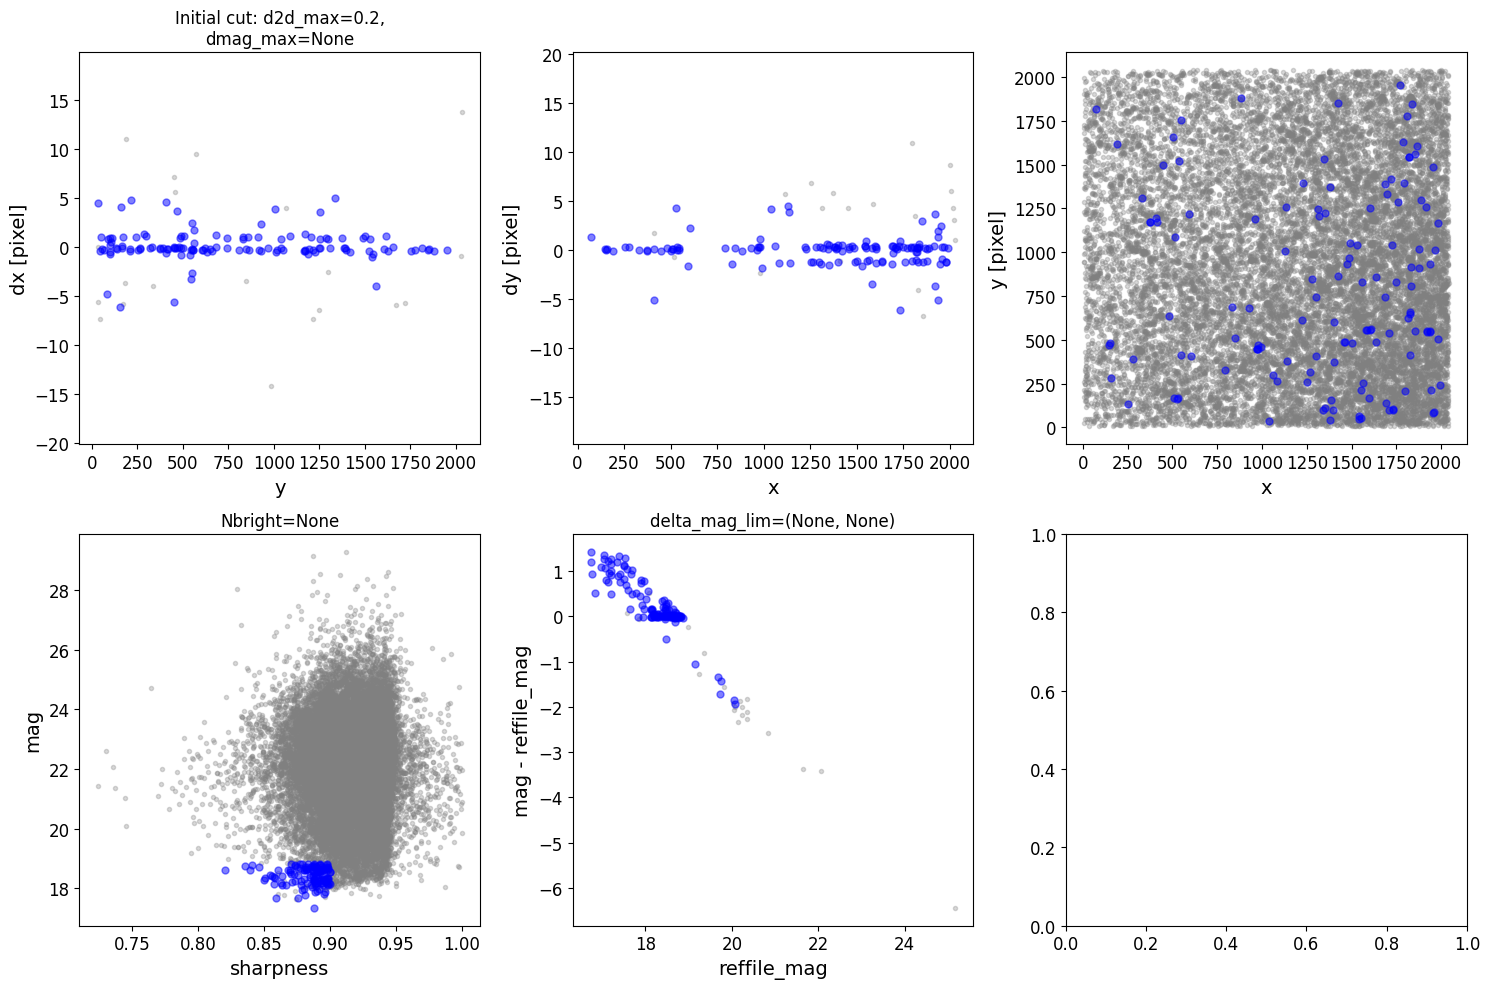

    slope  intercept    maxval  index  d_bestguess  fwhm  multimax
-0.000098        0.1 60.575986    331    -0.244798  0.62     False
d_rot_tmp 0.5552015869387816
Keeping 83 out of 83, skippin 0 because of null values in columns d_rot_tmp
median: -0.262339
75.000000 percentile cut: max residual for cut: 0.198108
__tmp_residuals 0.19810830355685785
median: -0.246607
i:00 mean:-0.246607(0.013472) stdev:0.105218(0.009449) X2norm:0.99 Nchanged:0 Ngood:62 Nclip:21

mean: -0.255196
i:01 mean:-0.255196(0.015615) stdev:0.131576(0.010965) X2norm:1.00 Nchanged:10 Ngood:72 Nclip:11

mean: -0.246061
i:02 mean:-0.246061(0.016505) stdev:0.141016(0.011591) X2norm:1.00 Nchanged:2 Ngood:74 Nclip:9

mean: -0.246061
i:03 mean:-0.246061(0.016505) stdev:0.141016(0.011591) X2norm:1.00 Nchanged:0 Ngood:74 Nclip:9


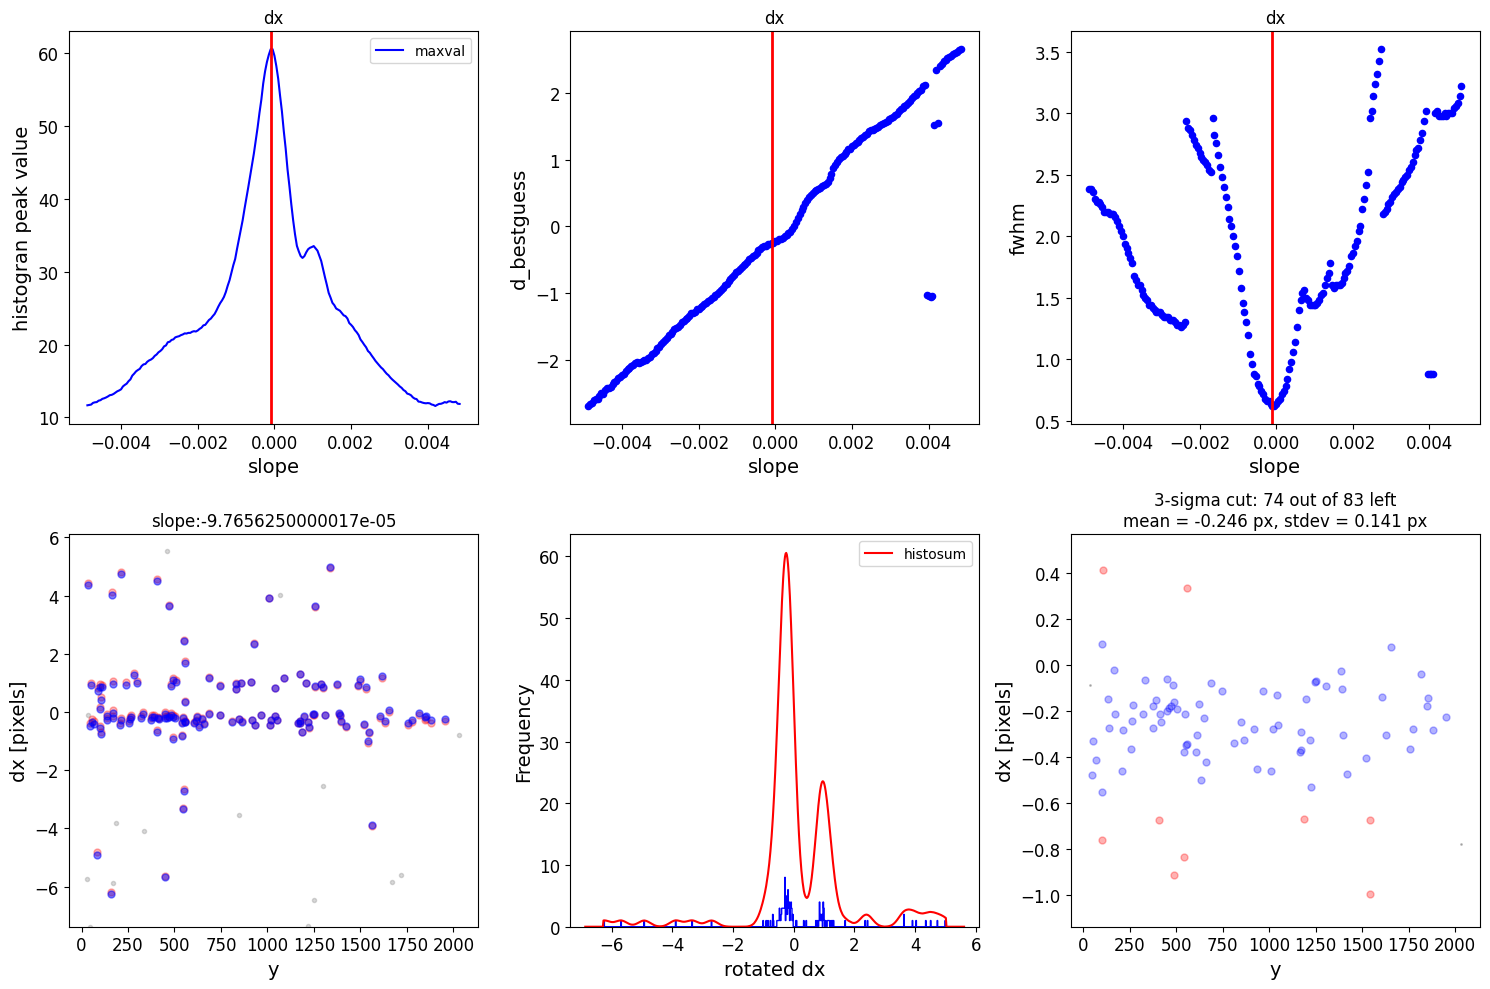

   slope  intercept    maxval  index  d_bestguess  fwhm  multimax
0.000146      -0.15 36.019325    291     0.161306  0.62     False
d_rot_tmp 0.9613062091257618
Keeping 47 out of 47, skippin 0 because of null values in columns d_rot_tmp
median: 0.140086
75.000000 percentile cut: max residual for cut: 0.179913
__tmp_residuals 0.17991348478884162
median: 0.139554
i:00 mean:0.139554(0.016754) stdev:0.097694(0.011677) X2norm:0.99 Nchanged:0 Ngood:35 Nclip:12

mean: 0.162197
i:01 mean:0.162197(0.020169) stdev:0.129142(0.014091) X2norm:1.00 Nchanged:7 Ngood:42 Nclip:5

mean: 0.166399
i:02 mean:0.166399(0.022572) stdev:0.149726(0.015783) X2norm:1.00 Nchanged:3 Ngood:45 Nclip:2

mean: 0.166399
i:03 mean:0.166399(0.022572) stdev:0.149726(0.015783) X2norm:1.00 Nchanged:0 Ngood:45 Nclip:2


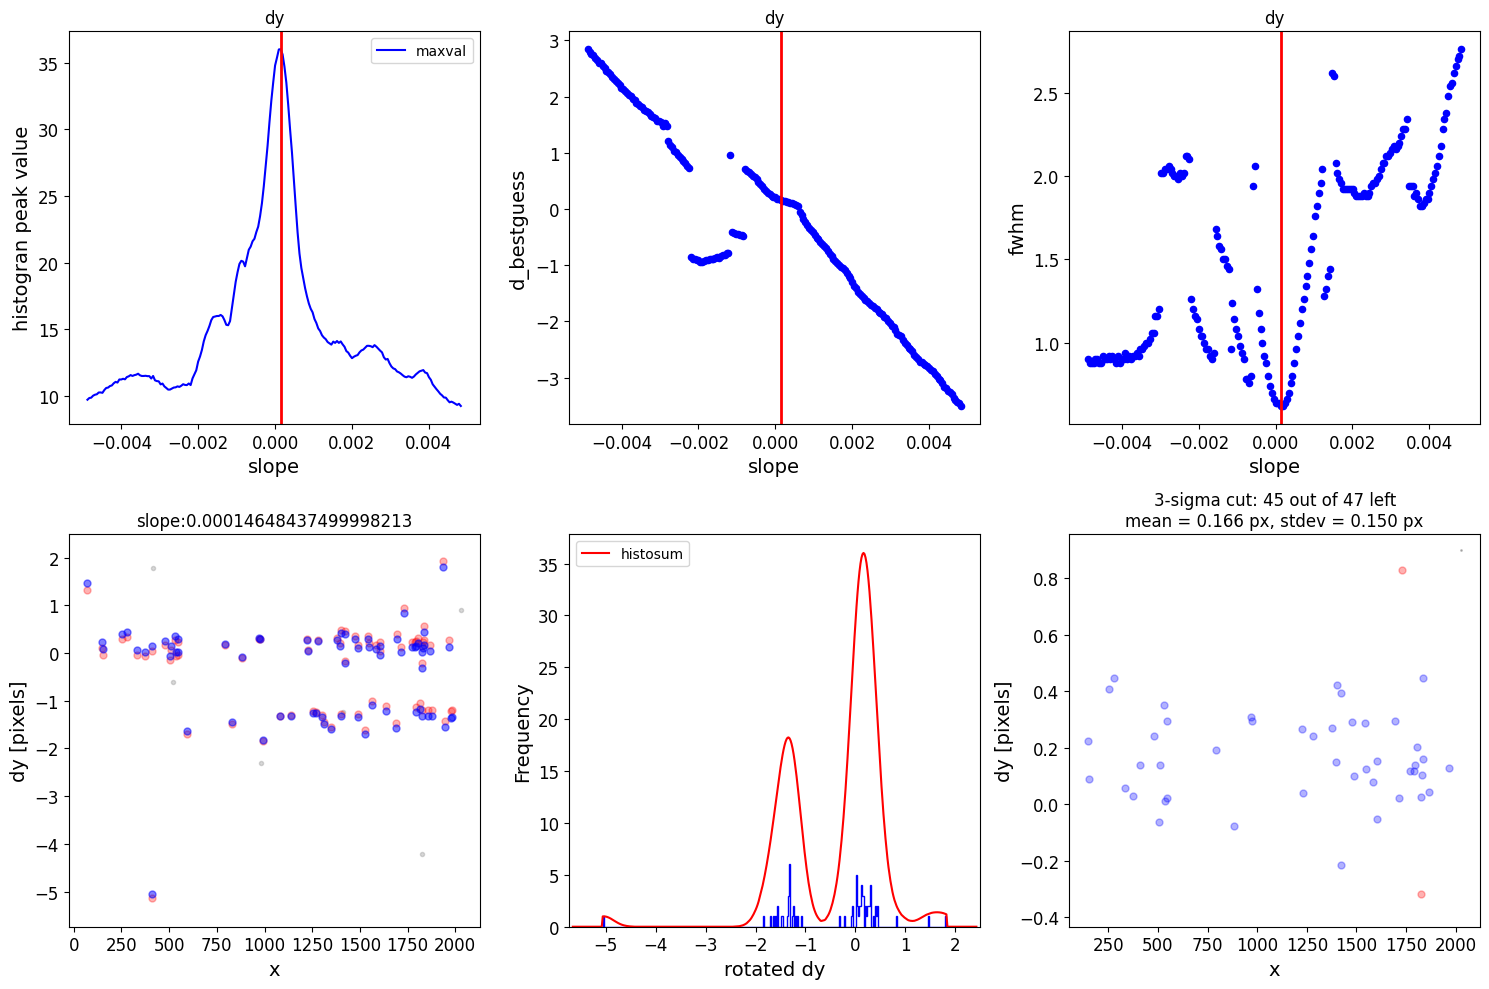

*** Note: close plots to continue!


<Figure size 640x480 with 0 Axes>

2024-09-13 09:37:42,604 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.
2024-09-13 09:37:43,177 - stpipe.TweakRegStep - INFO - Step TweakRegStep running with args ([<ImageModel(2048, 2048) from jw01334001001_02101_00002_nrca4_cal.fits>],).
2024-09-13 09:37:43,185 - stpipe.TweakRegStep - INFO - Step TweakRegStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /home/aswin/hst123/jwstred_temp/jw01334001001_02101_00002_nrca4_jhat.fits
  output_dir: ./jwstred_temp
  output_ext: .fits
  output_use_model: True
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_catalogs: False
  catalog_format: ecsv
  kernel_fwhm: 2.5
  snr_threshold: 50
  brightest: 4000
  peakmax: None
  enforce_user_order: False
  expand_refcat: False
  minobj: 4
  searchrad: 0.5
  use2dhist: True
  separation: 9
  tolerance: 0.7
  xoffset: 0
  yoffset: 0
  fitgeometry: rshift
  nclip: 3
  sigma: 3.0
  align_to_gaia: Fals

replacing SIP ./jwstred_temp/jw01334001001_02101_00002_nrca4_jhat.fits


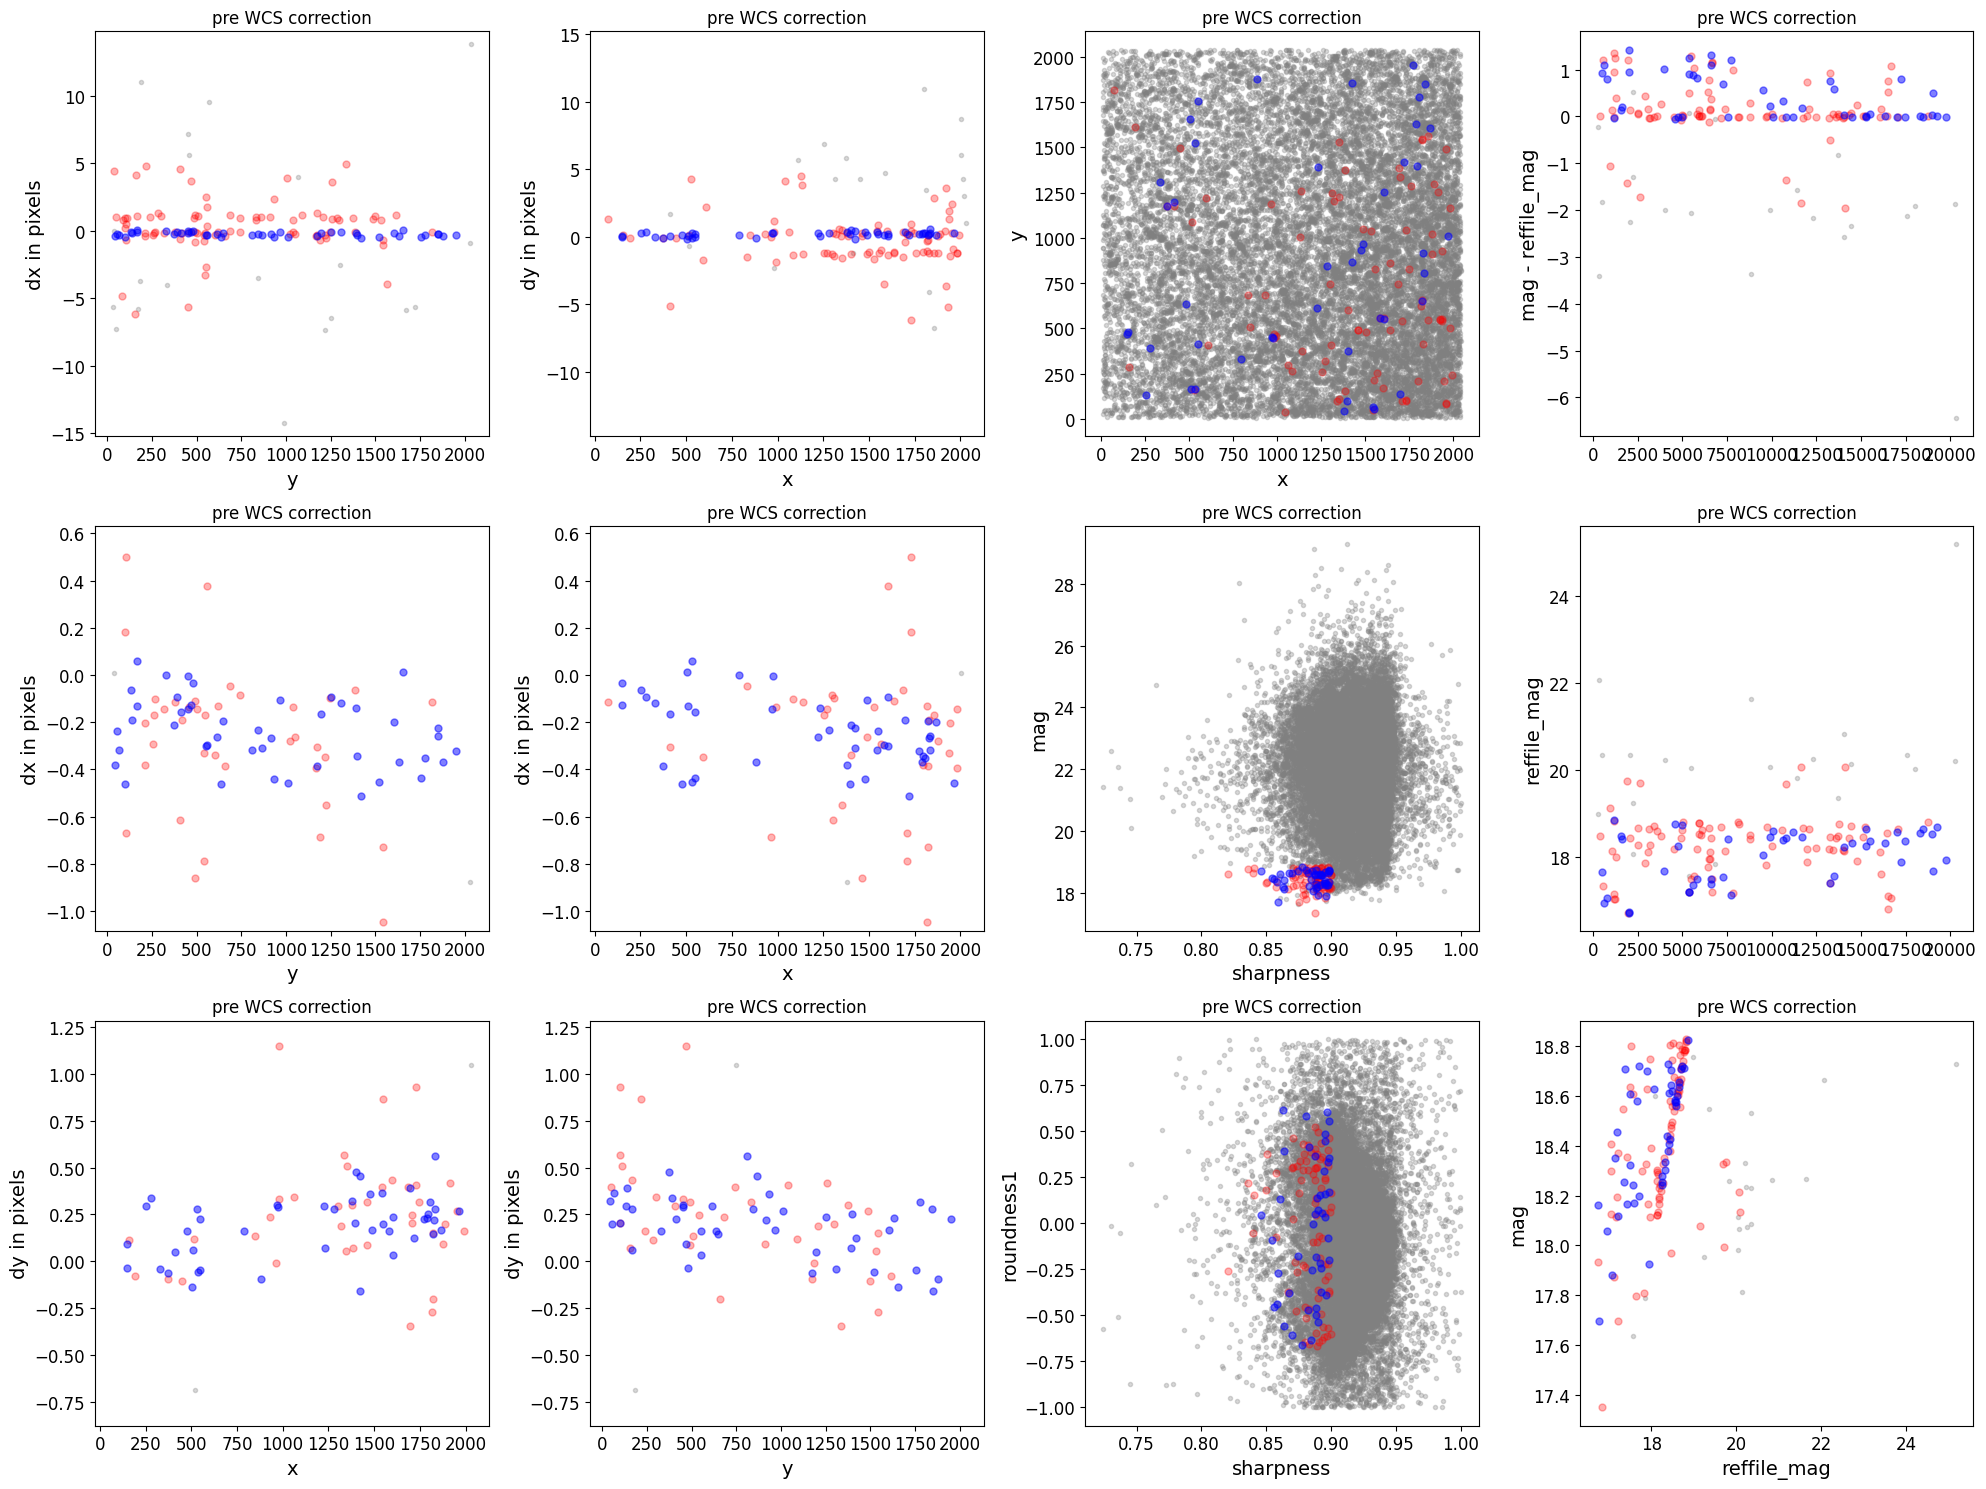

./jwstred_temp/jw01334001001_02101_00002_nrca4_jhat.fits


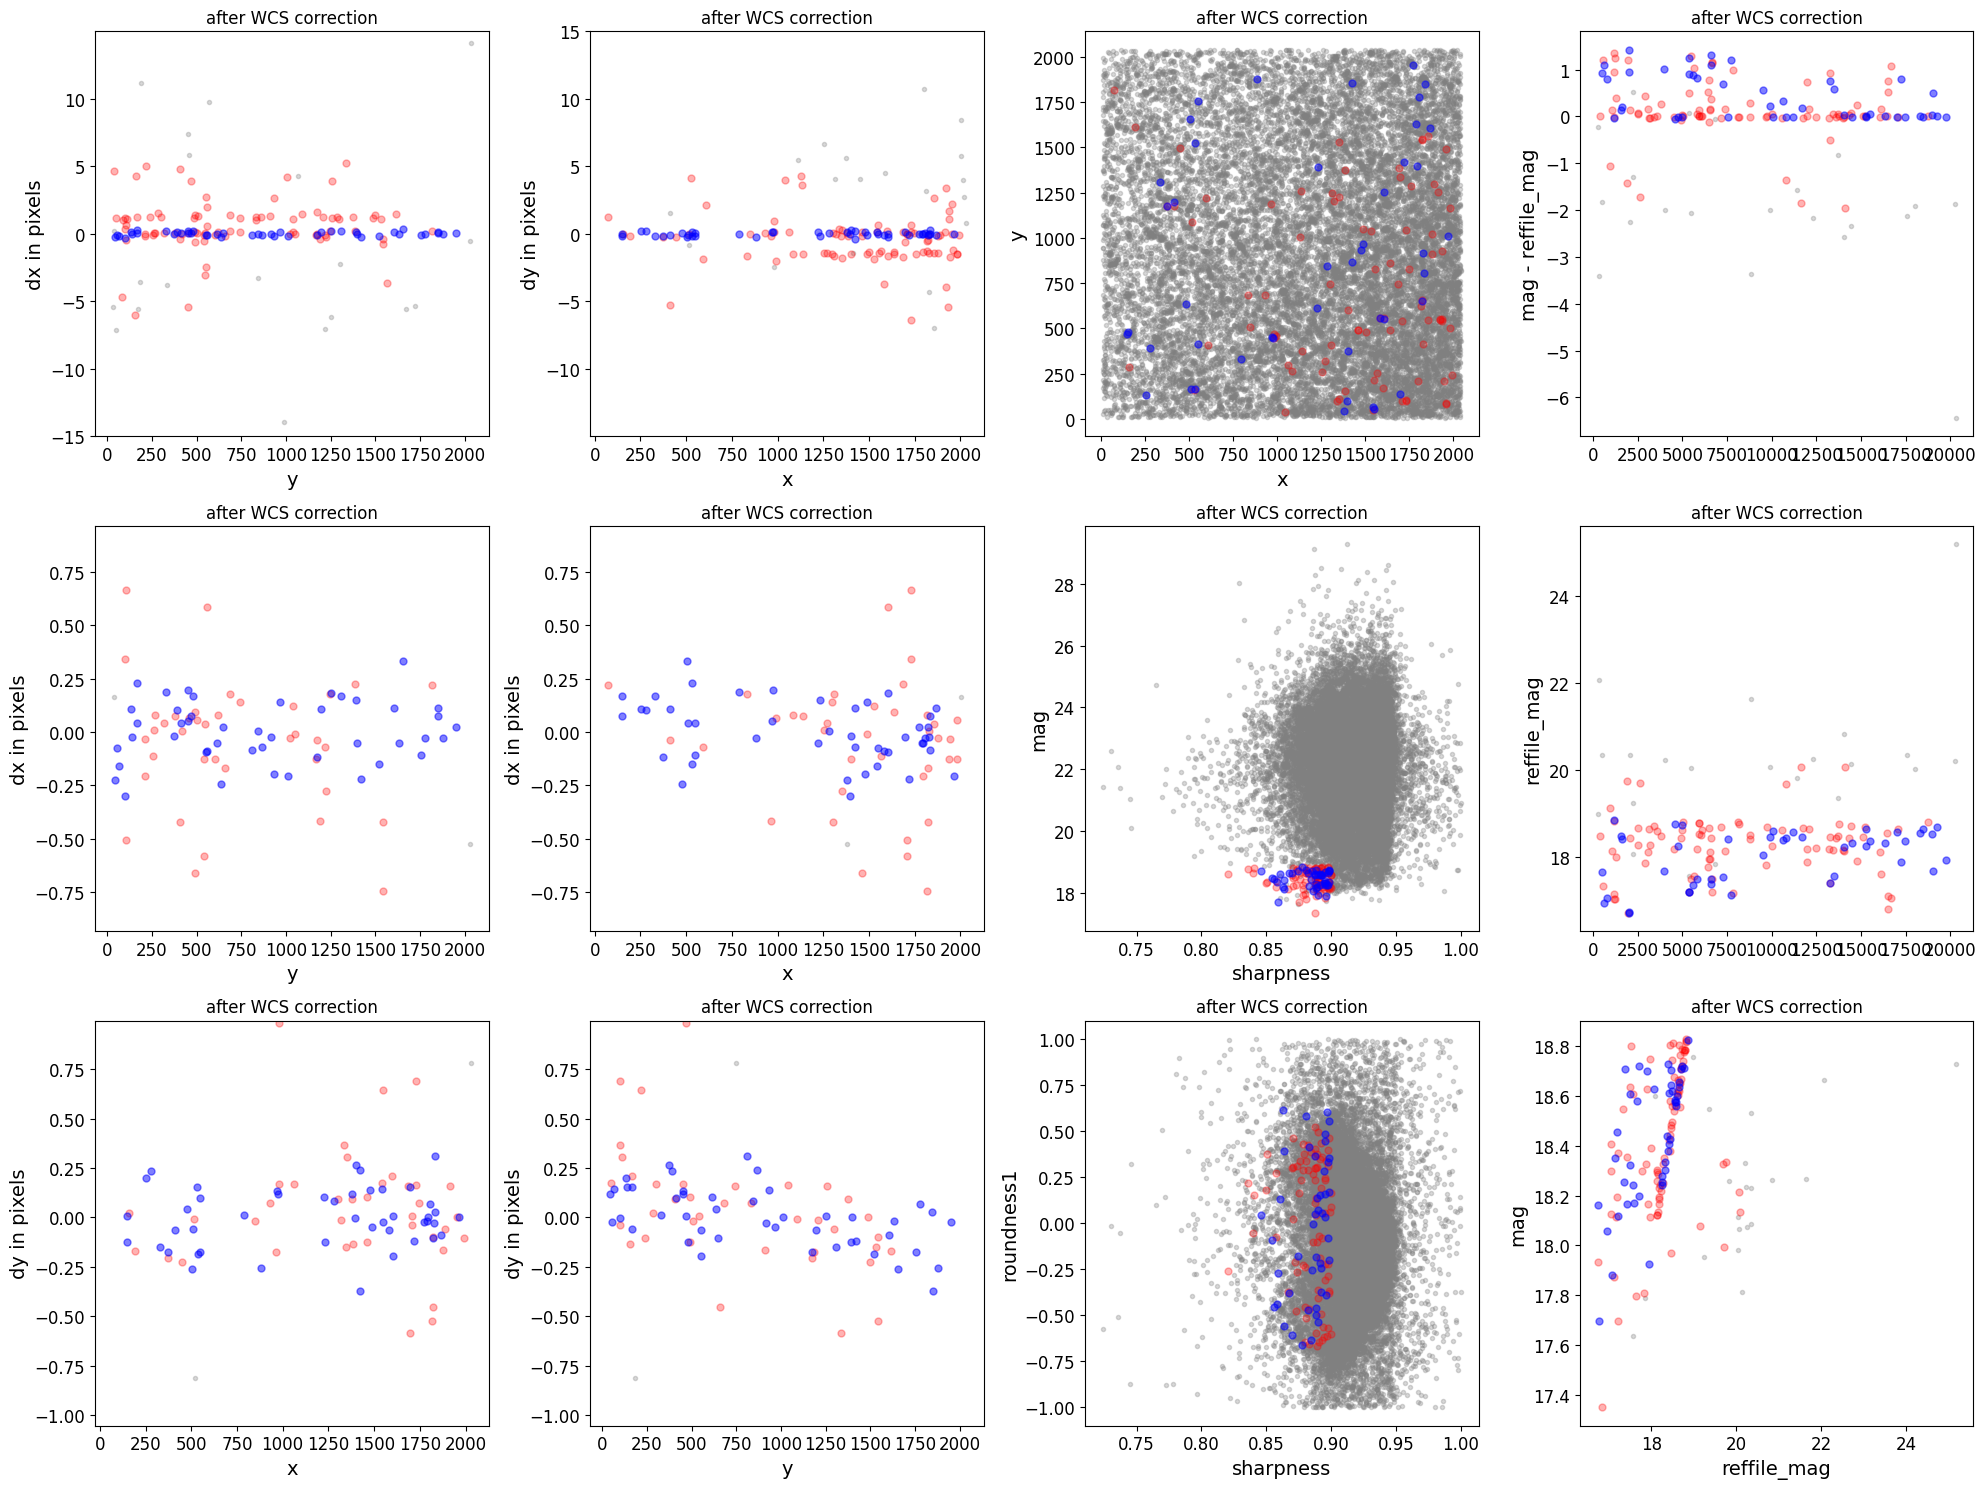

*** Note: close plots to continue!


0

In [14]:
wcs_align = st_wcs_align()


wcs_align.run_all(align_image,
		  telescope='jwst',
		  outsubdir='jwstred_temp',
          refcat_racol='ra',
          refcat_deccol='dec',
          refcat_magcol='mag',
          refcat_magerrcol='dmag',
          overwrite=True,
          d2d_max=.2,
          showplots=2,
          find_stars_threshold=3,
          refcatname=ref_catname,
          histocut_order='dxdy',
              sharpness_lim=(0.3,0.9),
              roundness1_lim=(-0.7, 0.7),
              SNR_min= 5,
              dmag_max=1.0,
              Nbright=150,
              objmag_lim =(14,24))

**Check the Output**

The reference image has not changed, but let's read in the newly
aligned image and compare with the original. 
subsequent correction needed for optimal alignment.



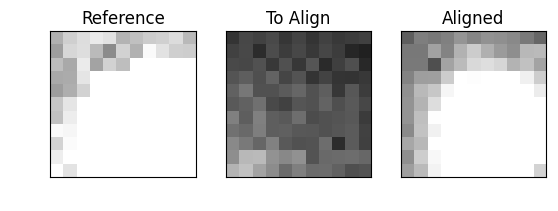

In [7]:
aligned_image = os.path.join('jwstred_temp',os.path.basename(align_image).replace('cal.fits','jhat.fits'))
aligned_fits = fits.open(aligned_image)
aligned_data = fits.open(aligned_image)['SCI',1].data
aligned_y,aligned_x = skycoord_to_pixel(star_location,wcs.WCS(aligned_fits['SCI',1],aligned_fits))
aligned_cutout = extract_array(aligned_data,(11,11),(aligned_x,aligned_y))

norm3 = simple_norm(aligned_cutout,stretch='linear',min_cut=-.5,max_cut=3)
fig,axes = plt.subplots(1,3)
axes[0].imshow(ref_cutout, origin='lower',
                      norm=norm1,cmap='gray')
axes[1].imshow(align_cutout, origin='lower',
                      norm=norm2,cmap='gray')
axes[2].imshow(aligned_cutout, origin='lower',
                      norm=norm3,cmap='gray')
axes[0].set_title('Reference')
axes[1].set_title('To Align')
axes[2].set_title('Aligned')
for i in range(3):
	axes[i].tick_params(labelcolor='none',axis='both',color='none')


plt.show()

## Align to Catalog

You can also align each image to the Gaia DR3 catalog, or you
could replace the catalog created in step one with your own
catalog of the field. 



In [5]:
align_image = glob.glob('jwstred_temp_gaia/jw01334001001_02101_00001_nrca4_cal.fits')[0]

0 ./jwstred_temp/jw01334001001_02101_00001_nrca4.phot.txt


2024-09-16 15:00:01,953 - stpipe.SourceCatalogStep - INFO - SourceCatalogStep instance created.
2024-09-16 15:00:05,379 - stpipe.SourceCatalogStep - INFO - Using APCORR reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_apcorr_0004.fits
2024-09-16 15:00:05,390 - stpipe.SourceCatalogStep - INFO - Using ABVEGAOFFSET reference file: /home/aswin/crds_cache/references/jwst/nircam/jwst_nircam_abvegaoffset_0002.asdf
2024-09-16 15:00:05,391 - stpipe - INFO - Instrument: NIRCAM
2024-09-16 15:00:05,392 - stpipe - INFO - Detector: NRCA4
2024-09-16 15:00:05,393 - stpipe - INFO - Filter: F090W
2024-09-16 15:00:05,393 - stpipe - INFO - Pupil: CLEAR
2024-09-16 15:00:05,393 - stpipe - INFO - Subarray: FULL
2024-09-16 15:00:05,422 - stpipe - WARNING - model.meta.resample.pixel_scale_ratio was not found. Assuming the native detector pixel scale (i.e., pixel_scale_ratio = 1)


dmag 0.36200000000000004
dmag 1
sharpness 0.9
roundness1 0.7
mag 25


2024-09-16 15:00:38,046 - stpipe - INFO - Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
Number of stars: 2670
### NO propoer motion correction!!!
Number of stars after removing nan's: 2670
x 2008
y 2008
gaia_d2d 0.5
*** Note: close plot to continue!


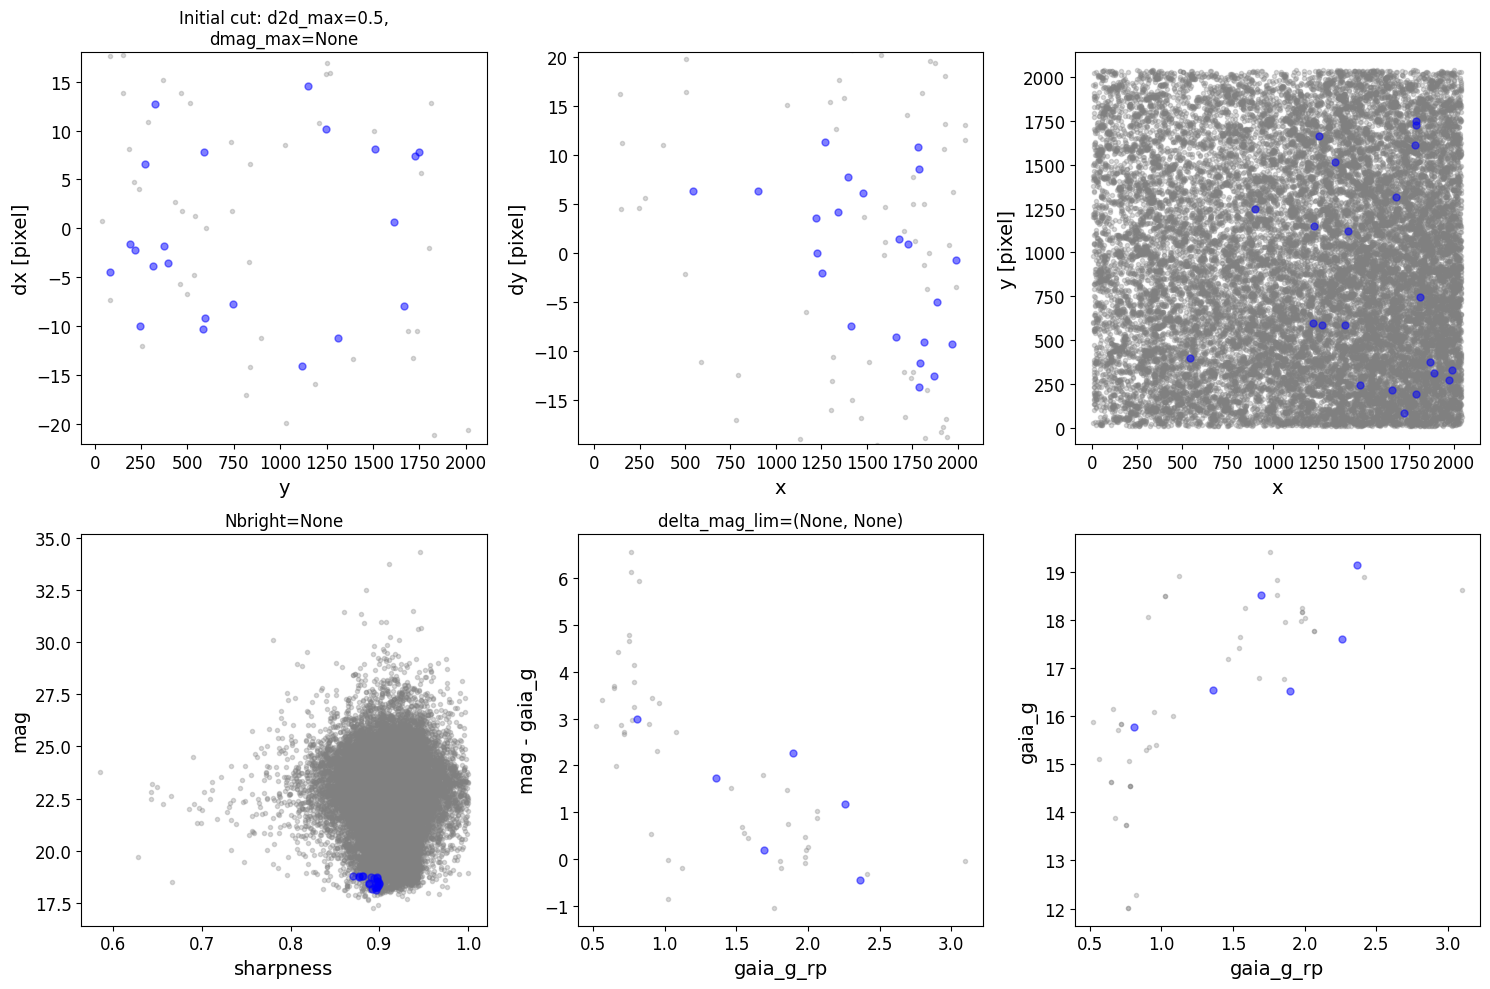

   slope  intercept   maxval  index  d_bestguess  fwhm  multimax
0.003418       -3.5 3.841245    680    -1.344142   0.5     False
d_rot_tmp -0.544142095509996
Keeping 4 out of 4, skippin 0 because of null values in columns d_rot_tmp
median: -1.339057
75.000000 percentile cut: max residual for cut: 0.081996
__tmp_residuals 0.08199623570269399
median: -1.350450
i:00 mean:-1.350450(0.041598) stdev:0.058828(0.024016) X2norm:0.79 Nchanged:0 Ngood:3 Nclip:1

mean: -1.338575
i:01 mean:-1.338575(0.039251) stdev:0.067986(0.024037) X2norm:1.00 Nchanged:1 Ngood:4 Nclip:0

mean: -1.338575
i:02 mean:-1.338575(0.039251) stdev:0.067986(0.024037) X2norm:1.00 Nchanged:0 Ngood:4 Nclip:0


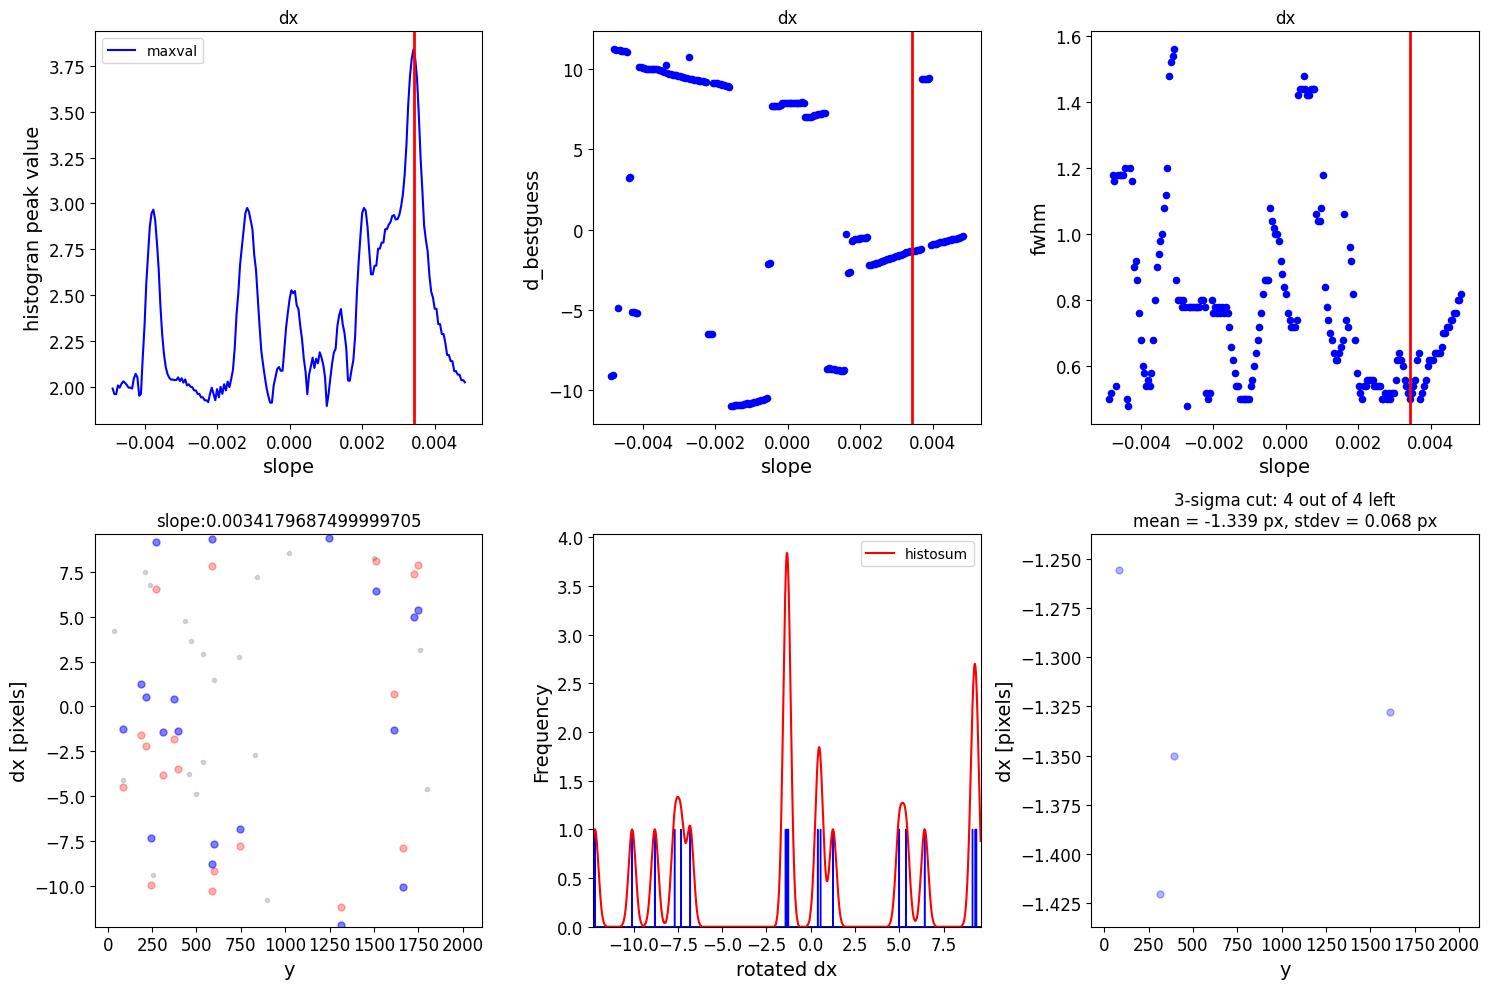

   slope  intercept   maxval  index  d_bestguess  fwhm  multimax
-0.00459        4.7 1.995012    292     4.173845   0.5      True
d_rot_tmp 4.973845451455637
Keeping 2 out of 2, skippin 0 because of null values in columns d_rot_tmp
median: 4.185105
i:00 mean:4.185105(0.031366) stdev:0.031366(0.015683) X2norm:0.64 Nchanged:0 Ngood:2 Nclip:0

mean: 4.185105
i:01 mean:4.185105(0.025026) stdev:0.025026(0.012513) X2norm:1.00 Nchanged:0 Ngood:2 Nclip:0


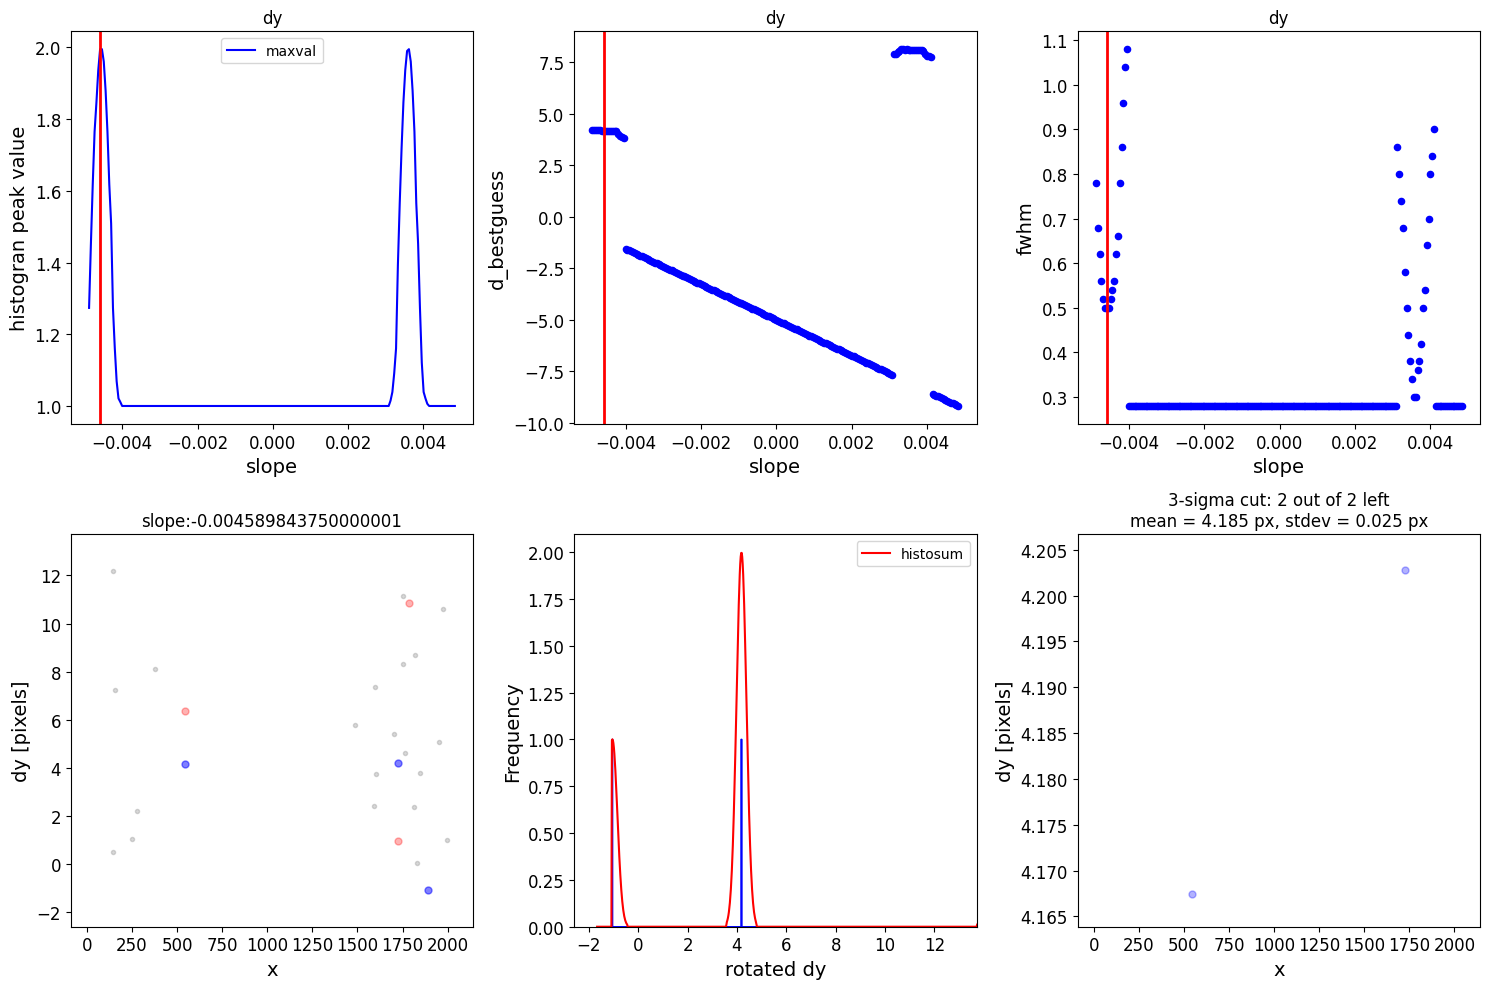

*** Note: close plots to continue!


<Figure size 640x480 with 0 Axes>

2024-09-16 15:00:42,709 - stpipe.TweakRegStep - INFO - TweakRegStep instance created.
2024-09-16 15:00:43,050 - stpipe.TweakRegStep - INFO - Step TweakRegStep running with args ([<ImageModel(2048, 2048) from jw01334001001_02101_00001_nrca4_cal.fits>],).
2024-09-16 15:00:43,054 - stpipe.TweakRegStep - INFO - Step TweakRegStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: /home/aswin/hst123/jwstred_temp/jw01334001001_02101_00001_nrca4_jhat.fits
  output_dir: ./jwstred_temp
  output_ext: .fits
  output_use_model: True
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_catalogs: False
  catalog_format: ecsv
  kernel_fwhm: 2.5
  snr_threshold: 50
  brightest: 4000
  peakmax: None
  enforce_user_order: False
  expand_refcat: False
  minobj: 4
  searchrad: 0.5
  use2dhist: True
  separation: 9
  tolerance: 0.7
  xoffset: 0
  yoffset: 0
  fitgeometry: rshift
  nclip: 3
  sigma: 3.0
  align_to_gaia: Fals

replacing SIP ./jwstred_temp/jw01334001001_02101_00001_nrca4_jhat.fits


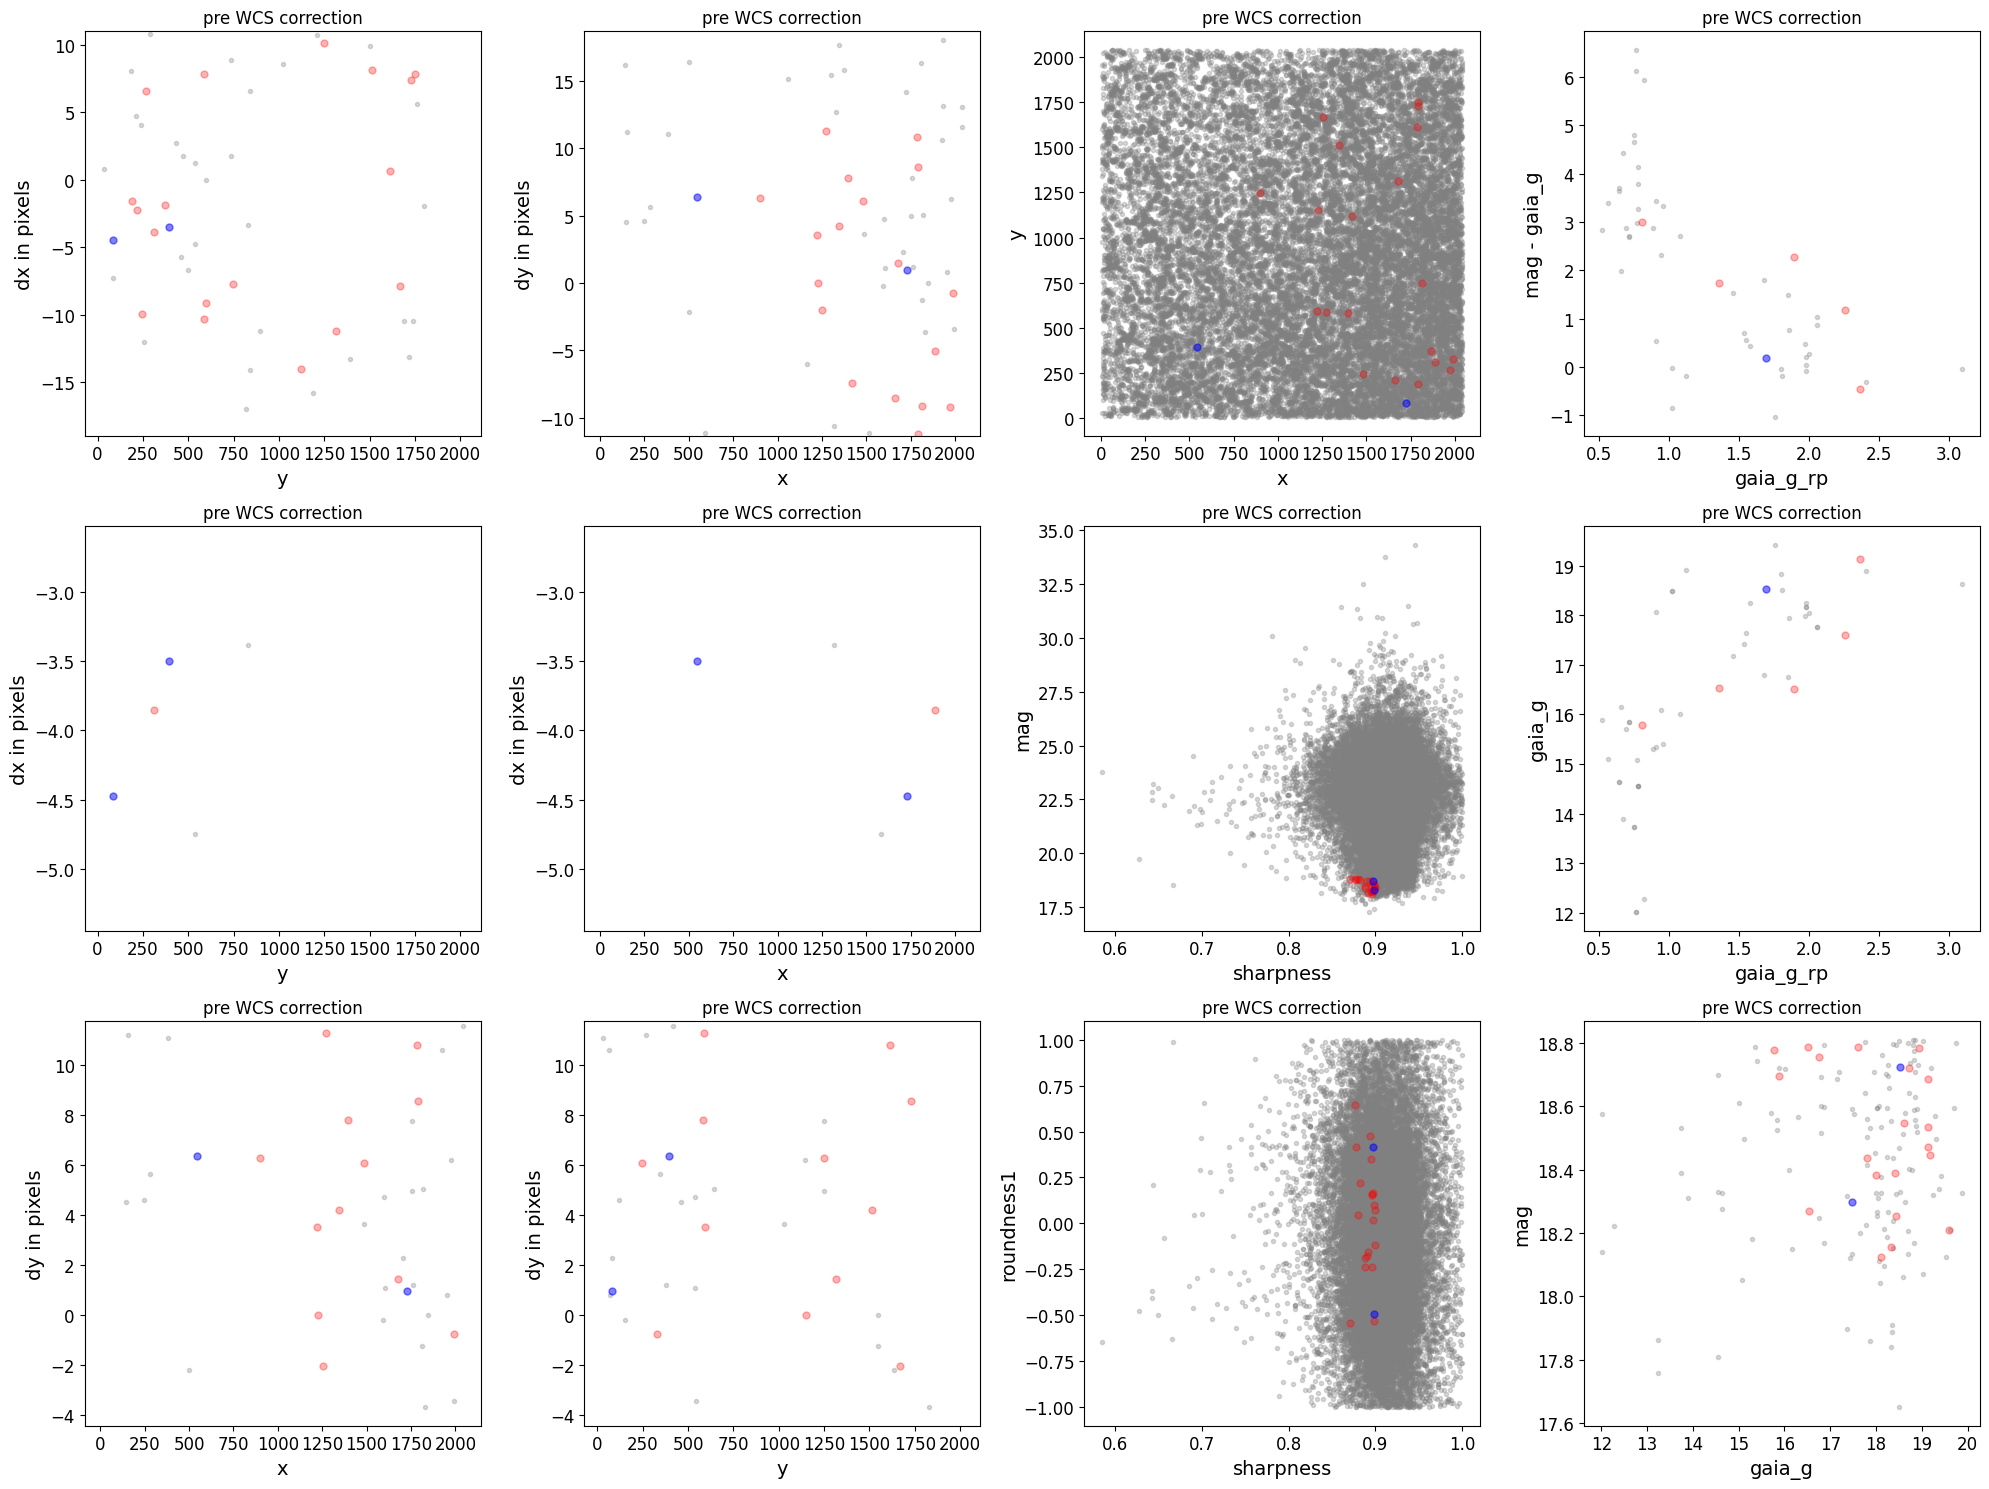

./jwstred_temp/jw01334001001_02101_00001_nrca4_jhat.fits


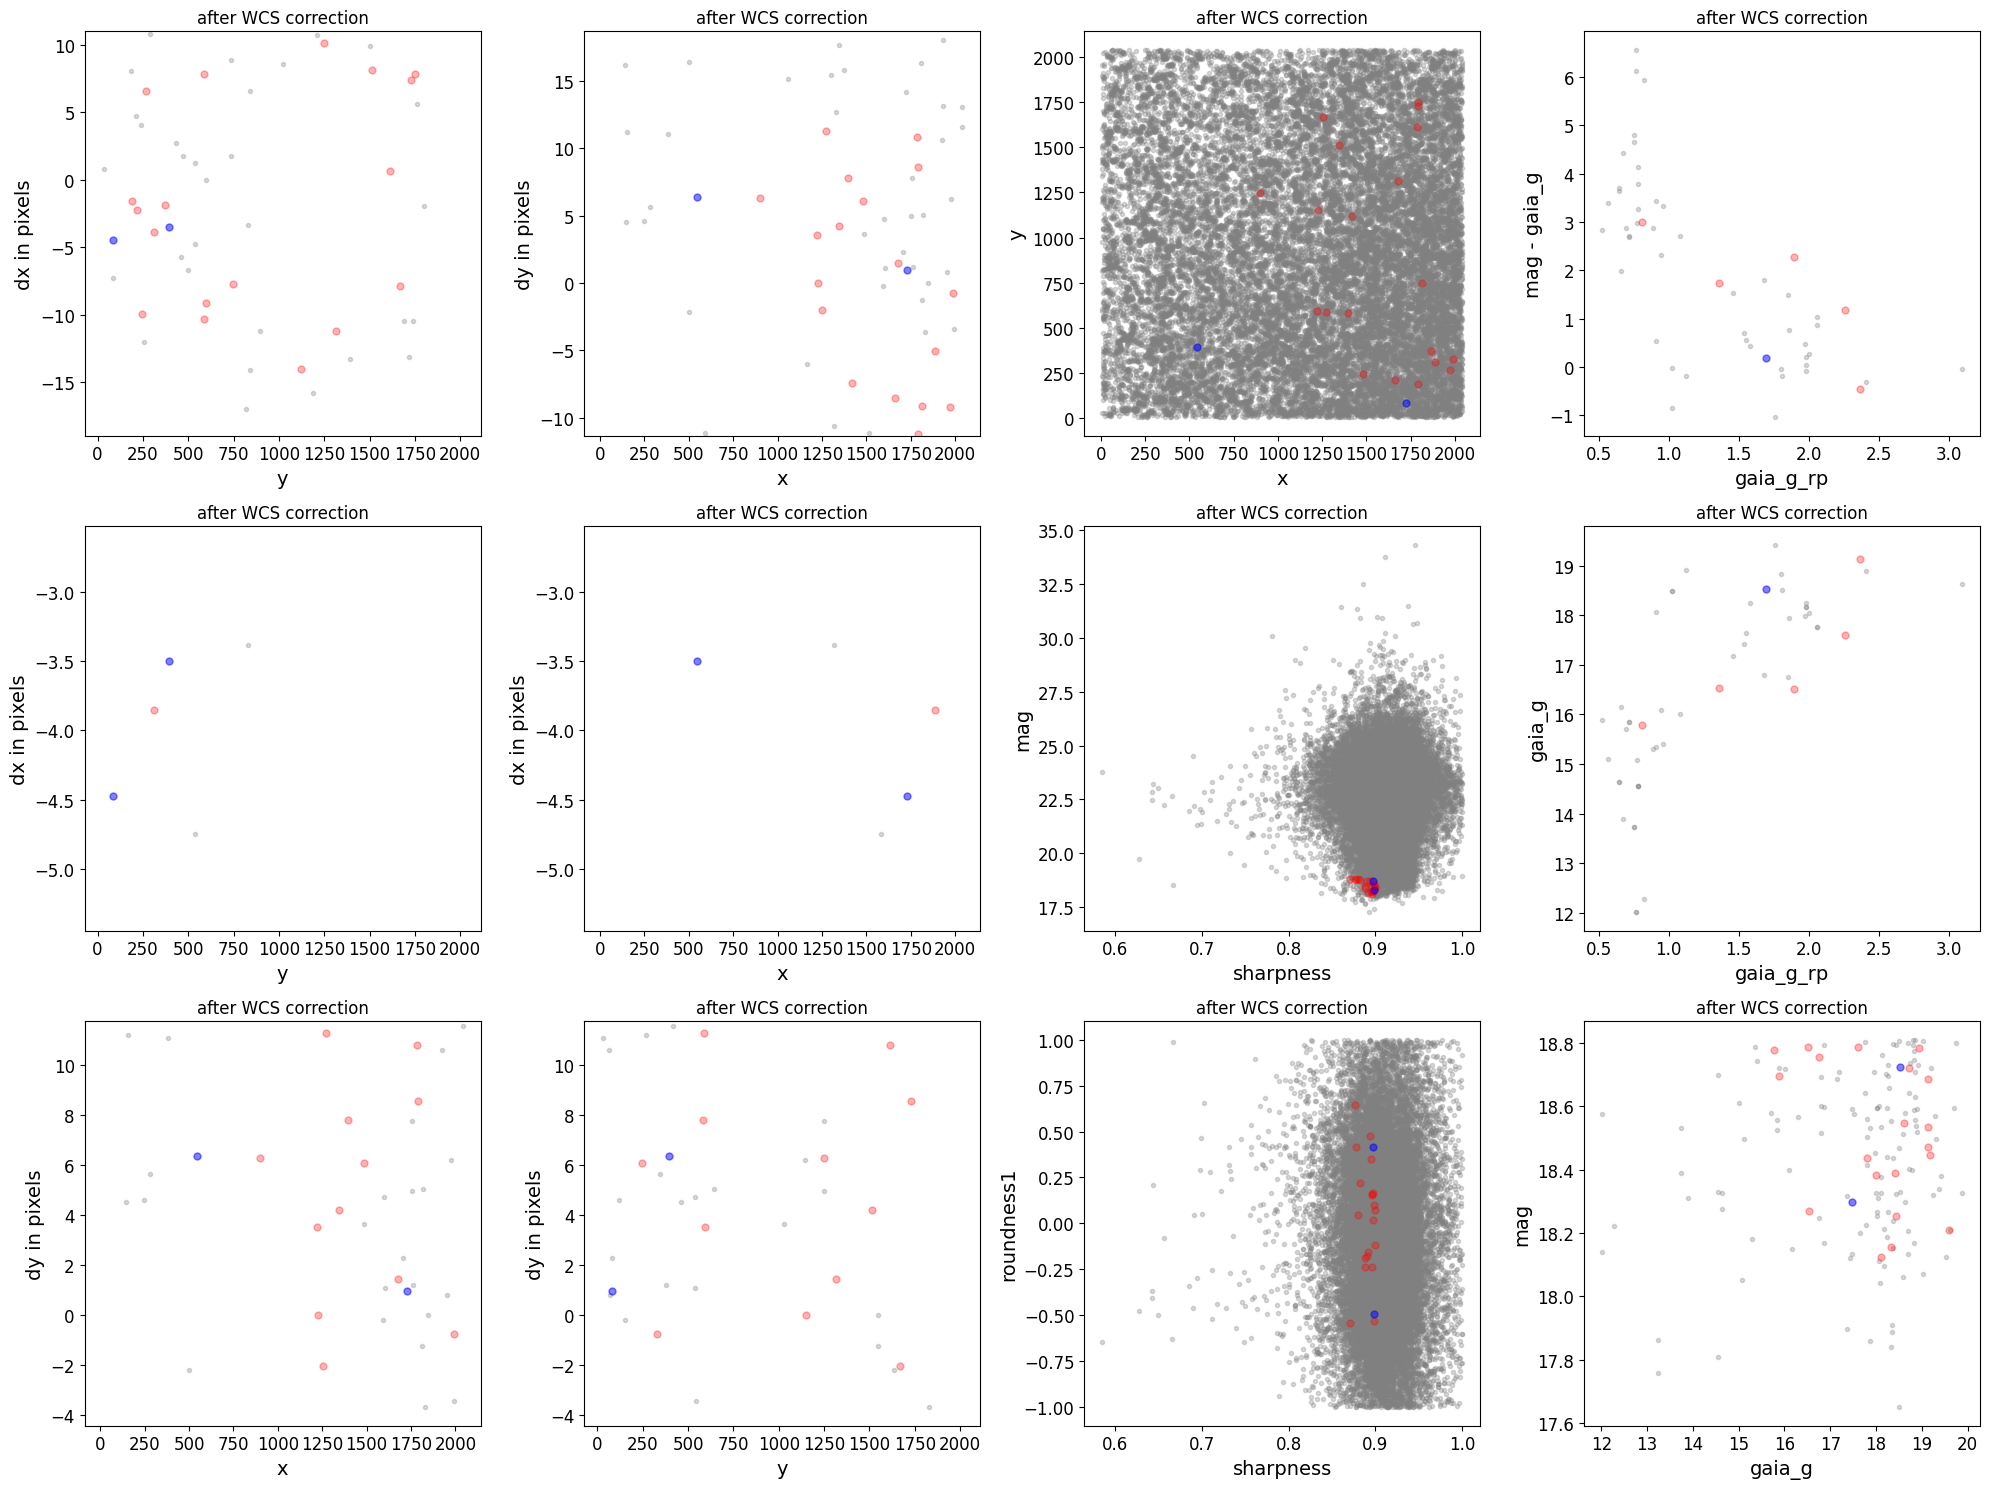

*** Note: close plots to continue!


0

In [6]:
wcs_align = st_wcs_align()

# if os.path.exists('Gaia_reference_catalog.txt'):
#     os.remove('Gaia_reference_catalog.txt')
    
wcs_align.run_all(align_image,
		  telescope='jwst',
		  outsubdir='jwstred_temp',
          overwrite=True,
          d2d_max=.5,
          find_stars_threshold = 1.1,
          showplots=2,
          refcatname='Gaia',
          histocut_order='dxdy',
              sharpness_lim=(0.3,0.9),
              roundness1_lim=(-0.7, 0.7),
              SNR_min= 3,
              dmag_max=1,
              Nbright = 150,
              objmag_lim =(15,25))

# aligned_image = os.path.join('jwstred_temp',os.path.basename(align_image).replace('cal.fits','jhat.fits'))
# aligned_fits = fits.open(aligned_image)
# aligned_data = fits.open(aligned_image)['SCI',1].data
# aligned_y,aligned_x = skycoord_to_pixel(star_location,wcs.WCS(aligned_fits['SCI',1],aligned_fits))
# aligned_cutout = extract_array(aligned_data,(11,11),(aligned_x,aligned_y))

# norm3 = simple_norm(aligned_cutout,stretch='linear',min_cut=-.5,max_cut=3)
# fig,axes = plt.subplots(1,2)
# axes[0].imshow(align_cutout, origin='lower',
#                       norm=norm2,cmap='gray')
# axes[1].imshow(aligned_cutout, origin='lower',
#                       norm=norm3,cmap='gray')
# axes[0].set_title('To Align')
# axes[1].set_title('Aligned')
# for i in range(2):
# 	axes[i].tick_params(labelcolor='none',axis='both',color='none')


# plt.show()

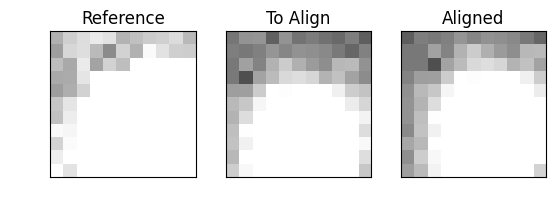

In [32]:
norm3 = simple_norm(aligned_cutout,stretch='linear',min_cut=-.5,max_cut=3)
fig,axes = plt.subplots(1,3)
axes[0].imshow(ref_cutout, origin='lower',
                      norm=norm1,cmap='gray')
axes[1].imshow(align_cutout, origin='lower',
                      norm=norm2,cmap='gray')
axes[2].imshow(aligned_cutout, origin='lower',
                      norm=norm3,cmap='gray')
axes[0].set_title('Reference')
axes[1].set_title('To Align')
axes[2].set_title('Aligned')
for i in range(3):
	axes[i].tick_params(labelcolor='none',axis='both',color='none')


plt.show()

#### Gaia xmatch

In [7]:
from jwst.datamodels import ImageModel

In [13]:
im = fits.open(align_image)

hdr = im['SCI'].header
nx = hdr['NAXIS1']
ny = hdr['NAXIS2']

image_model = ImageModel(im)

ra0,dec0 = image_model.meta.wcs(nx/2.0-1,ny/2.0-1)
coord0 = SkyCoord(ra0,dec0,unit=(u.deg, u.deg), frame='icrs')
radius_deg = []
for x in [0,nx-1]:        
    for y in [0,ny-1]:     
        ra,dec = image_model.meta.wcs(x,y)
        radius_deg.append(coord0.separation(SkyCoord(ra,dec,unit=(u.deg, u.deg), frame='icrs')).deg)
radius_deg = np.amax(radius_deg)*1.1

In [14]:
dr = 'gaiadr3'

query ="SELECT * FROM {}.gaia_source WHERE CONTAINS(POINT('ICRS',\
        {}.gaia_source.ra,{}.gaia_source.dec),\
        CIRCLE('ICRS',{},{} ,{}))=1;".format(dr,dr,dr,ra0,dec0,radius_deg)

job5 = Gaia.launch_job_async(query)
tb_gaia = job5.get_results() 
print("Number of stars:",len(tb_gaia))

2024-09-16 15:20:46,146 - stpipe - INFO - Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
Number of stars: 1446


In [27]:
tb_gaia

<Table length=1446>
    solution_id             DESIGNATION          ... libname_gspphot
                                                 ...                
       int64                   object            ...      object    
------------------- ---------------------------- ... ---------------
1636148068921376768 Gaia DR3 1360405022423774592 ...                
1636148068921376768 Gaia DR3 1360405400378561920 ...                
1636148068921376768 Gaia DR3 1360405400378562048 ...                
1636148068921376768 Gaia DR3 1360405400380332544 ...                
1636148068921376768 Gaia DR3 1360405400380332800 ...                
1636148068921376768 Gaia DR3 1360405022421437824 ...                
1636148068921376768 Gaia DR3 1360405022423778048 ...                
1636148068921376768 Gaia DR3 1360405022423778944 ...                
1636148068921376768 Gaia DR3 1360405091143265920 ...                
                ...                          ... ...             ...
1636148068921376768 Gaia DR3 1360405675256795008 ...                
1636148068921376768 Gaia DR3 1360405675256821120 ...                
1636148068921376768 Gaia DR3 1360405675256821248 ...                
1636148068921376768 Gaia DR3 1360405675260824832 ...                
1636148068921376768 Gaia DR3 1360405675260823808 ...                
1636148068921376768 Gaia DR3 1360405675260824320 ...                
1636148068921376768 Gaia DR3 1360405675260829440 ...                
1636148068921376768 Gaia DR3 1360405675262442496 ...                
1636148068921376768 Gaia DR3 1360405675262448256 ...

In [15]:
align_image

'jwstred_temp_gaia/jw01334001001_02101_00001_nrca4_cal.fits'

In [28]:
jhat_df = pd.read_csv(glob.glob(align_image.replace('.fits', '.phot.txt'))[0], sep = '\s+') #useful
# jhat_df[['x', 'y']].to_csv('region.csv', header = None, index = False)

In [44]:
jh_ra, jh_dec = jhat_df['ra'].to_numpy()*u.degree, jhat_df['dec'].to_numpy()*u.degree
jh_skycoord = SkyCoord(ra = jh_ra, dec = jh_dec)
ga_ra, ga_dec = np.array(tb_gaia['ra'])*u.degree, np.array(tb_gaia['dec'])*u.degree
ga_skycoord = SkyCoord(ra = ga_ra, dec = ga_dec)

In [46]:
#which catalog should be matched to the other?
idx, d2d, d3d = jh_skycoord.match_to_catalog_sky(ga_skycoord)

In [74]:
#figure out indices
idx_ga, idx_jh, d2d, d3d = jh_skycoord.search_around_sky(ga_skycoord, 1*u.arcsec)  

In [77]:
len(np.unique(idx_ga)), len(np.unique(idx_jh))

(785, 10316)

In [58]:
len(idx), len(np.unique(idx)), len(jh_skycoord)

(20552, 810, 20552)

In [62]:
(d2d < 5*u.arcsec).sum()

311367

In [66]:
jh_skycoord[idx]

<SkyCoord (ICRS): (ra, dec) in deg
    [(259.25563 , 43.131695), (259.255766, 43.131682),
     (259.270284, 43.133474), ..., (259.252901, 43.131143),
     (259.248868, 43.130856), (259.271036, 43.13396 )]>